In [2]:
import numpy as np
import pandas as pd
import ccxt
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import talib
import requests
from gym import spaces, Env

url = "https://api.binance.com/api/v3/klines"
params = {
    'symbol': 'BTCUSDT',  # The trading pair
    'interval': '1m',     # 1-minute candlesticks
    'limit': 50000        # Number of data points to fetch
}

response = requests.get(url, params=params)
data = response.json()

if response.status_code == 200:
    data = pd.DataFrame(
        data,
        columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                    'close_time', 'quote_asset_volume', 'number_of_trades', 
                    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    )
    data = data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    #data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    # data.set_index('timestamp', inplace=True)
    data = data.astype(float)
else:
    print(f"Error: {response.status_code}, {response.text}")
data
data.to_csv('btc_data.csv', index=False)
data

,timestamp,open,high,low,close,volume
0,1.739905e+12,93766.70,93782.50,93732.39,93766.01,8.09103
1,1.739905e+12,93766.01,93809.44,93735.51,93751.77,19.75982
2,1.739905e+12,93751.77,93762.46,93727.20,93734.15,11.39068
3,1.739906e+12,93734.16,93734.16,93640.77,93684.48,27.40839
4,1.739906e+12,93684.48,93684.48,93610.00,93659.40,27.60298
...,...,...,...,...,...,...
995,1.739965e+12,96296.01,96317.92,96296.00,96308.28,6.16185
996,1.739965e+12,96308.29,96308.29,96298.58,96308.28,5.18950
997,1.739965e+12,96308.28,96308.29,96291.00,96291.00,3.40701
998,1.739965e+12,96291.00,96291.01,96264.15,96264.16,8.99467


In [9]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Adaptive Deep Learning-Based Trading Strategies Using Reinforcement Learning and Meta-Learning

This full implementation includes:
    - Data loading (from Binance API) and noise filtering (using wavelet transform and FFT)
    - A custom trading environment (based on OpenAI Gym)
    - Hyperparameter tuning using Bayesian Optimization and Genetic Algorithm (all placed in main())
    - RL agent training (using PPO from stable-baselines3)
    - Meta-learning adaptation on new market conditions
    - Example of how to load and use the trained model on a new dataset

Required packages:
    numpy, pandas, matplotlib, gym, torch, pywavelets, scipy, stable-baselines3, bayesian-optimization, deap, requests
"""

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim

import pywt  # For wavelet transforms
from scipy.fft import fft, ifft

# RL agent library (PPO is used in this implementation)
from stable_baselines3 import PPO

# For Bayesian Optimization
from bayes_opt import BayesianOptimization

# For Genetic Algorithm optimization using DEAP
from deap import base, creator, tools, algorithms

import random
import requests  # Needed for data download

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)


def load_data():
    """
    Generate synthetic BTC/USD 1-minute HLOCV data from Binance.
    Returns:
        df (pandas.DataFrame): DataFrame with columns 'Open', 'High', 'Low', 'Close', 'Volume'
    """
    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': 'BTCUSDT',  # The trading pair
        'interval': '1m',     # 1-minute candlesticks
        'limit': 5000         # Number of data points to fetch (adjust as needed)
    }

    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code == 200:
        data = pd.DataFrame(
            data,
            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                     'close_time', 'quote_asset_volume', 'number_of_trades', 
                     'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        )
        data = data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
        data.set_index('timestamp', inplace=True)
        data = data.astype(float)
    else:
        print(f"Error: {response.status_code}, {response.text}")
    data = data.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'})
    return data


def noise_filtering(data):
    """
    Apply noise filtering to the 'Close' price using wavelet transform and FFT.
    Args:
        data (pandas.DataFrame): Original data with a 'Close' column.
    Returns:
        data (pandas.DataFrame): Data with an additional column 'Close_filtered'.
    """
    signal = data['Close'].values
    
    # Plot original signal
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(data['Close'], label='Original Signal', color='blue')
    plt.title('Original Close Price')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()

    # Wavelet decomposition using Daubechies 1 (db1) with level=2
    coeff = pywt.wavedec(signal, 'db1', level=2)
    
    # Estimate noise sigma using median absolute deviation
    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    
    # Determine universal threshold
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    
    # Apply soft thresholding to coefficients
    coeff_filtered = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeff]
    
    # Reconstruct signal from filtered coefficients
    filtered_signal = pywt.waverec(coeff_filtered, 'db1')
    
    # Further filtering using FFT: remove high-frequency components
    fft_coeff = fft(filtered_signal)
    freq = np.fft.fftfreq(len(filtered_signal))
    
    # Zero out high-frequency components (threshold set at 0.1)
    fft_coeff[np.abs(freq) > 0.1] = 0
    filtered_signal_fft = np.fft.ifft(fft_coeff).real

    # Plot filtered signal after FFT
    plt.subplot(2, 1, 2)
    plt.plot(filtered_signal_fft, label='Filtered Signal', color='green')
    plt.title('Filtered Close Price')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()

    plt.tight_layout()
    plt.show()

    data['Close_filtered'] = filtered_signal_fft
    return data


class FeatureExtractor(nn.Module):
    """
    Hybrid feature extraction model combining CNN, LSTM, and Transformer Encoder.
    Although not directly integrated in the TradingEnv, this model can be used
    to extract predictive features from time-series data.
    """
    def __init__(self, input_dim, cnn_channels, lstm_hidden_size, transformer_dim, nhead, num_transformer_layers):
        super(FeatureExtractor, self).__init__()
        # CNN for local feature extraction (1D convolution)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # LSTM for capturing sequential dependencies
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden_size, batch_first=True)
        # Fully connected layer to map LSTM output to transformer dimension
        self.fc = nn.Linear(lstm_hidden_size, transformer_dim)
        # Transformer Encoder for global dependency modeling
        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)

    def forward(self, x):
        """
        Forward pass of the feature extractor.
        Args:
            x (torch.Tensor): Input tensor of shape (batch, seq_len, features)
        Returns:
            features (torch.Tensor): Extracted feature vector of shape (batch, transformer_dim)
        """
        # Rearrange for CNN: (batch, features, seq_len)
        x_cnn = x.transpose(1, 2)
        cnn_out = self.cnn(x_cnn)
        # Rearrange back: (batch, seq_len, channels)
        cnn_out = cnn_out.transpose(1, 2)
        # LSTM processing
        lstm_out, _ = self.lstm(cnn_out)
        # Map LSTM output to transformer dimension
        fc_out = self.fc(lstm_out)
        # Transformer expects input shape: (seq_len, batch, d_model)
        transformer_in = fc_out.transpose(0, 1)
        transformer_out = self.transformer(transformer_in)
        # Aggregate transformer outputs (mean over sequence length)
        features = transformer_out.mean(dim=0)
        return features  # Shape: (batch, transformer_dim)


class TradingEnv(gym.Env):
    """
    Custom trading environment for simulating BTC/USD trading.
    Observations: Sliding window of normalized filtered closing prices.
    Actions: 0 = Hold, 1 = Buy, 2 = Sell.
    Reward: Profit/loss realized in the next time step.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, data, window_size=20):
        super(TradingEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.window_size = window_size
        self.current_step = window_size
        # Define action space: Discrete with three actions
        self.action_space = spaces.Discrete(3)
        # Observation space: window of 'Close_filtered' prices, normalized
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(window_size, 1), dtype=np.float32)
        self.done = False
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.position = 0    # +1 for long, -1 for short, 0 for no position
        self.entry_price = 0
        self.total_profit = 0
        self.trades = []     # Log of trades

    def _get_observation(self):
        """
        Retrieve the current observation: a normalized sliding window of prices.
        """
        obs = self.data['Close_filtered'].values[self.current_step - self.window_size:self.current_step]
        current_price = obs[-1]
        obs = obs / current_price  # Normalize by current price
        return obs.reshape(-1, 1).astype(np.float32)

    def step(self, action):
        """
        Execute one time step within the environment.
        Args:
            action (int): The action taken by the agent.
        Returns:
            obs (np.array): Next observation.
            reward (float): Reward earned.
            done (bool): Whether the episode has ended.
            info (dict): Additional information.
        """
        current_price = self.data['Close_filtered'].values[self.current_step - 1]
        next_price = (self.data['Close_filtered'].values[self.current_step]
                      if self.current_step < len(self.data) else current_price)
        reward = 0

        # Execute action: Buy, Sell, or Hold
        if action == 1:  # Buy
            if self.position == 0:
                self.position = 1
                self.entry_price = current_price
                self.trades.append(('buy', self.current_step, current_price))
        elif action == 2:  # Sell
            if self.position == 0:
                self.position = -1
                self.entry_price = current_price
                self.trades.append(('sell', self.current_step, current_price))

        # Close position in the next step
        if self.position != 0:
            if self.position == 1:
                reward = next_price - self.entry_price  # Profit from long
            elif self.position == -1:
                reward = self.entry_price - next_price  # Profit from short
            self.balance += reward
            self.total_profit += reward
            self.position = 0  # Reset position

        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True

        obs = self._get_observation() if not self.done else np.zeros(self.observation_space.shape, dtype=np.float32)
        info = {'balance': self.balance, 'total_profit': self.total_profit}
        return obs, reward, self.done, info

    def reset(self):
        """
        Reset the environment state for a new episode.
        Returns:
            obs (np.array): Initial observation.
        """
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0
        self.total_profit = 0
        self.done = False
        self.trades = []
        return self._get_observation()

    def render(self, mode='human', close=False):
        """
        Render the environment state to the console.
        """
        print(f"Step: {self.current_step}, Balance: {self.balance}, Total Profit: {self.total_profit}")


def train_rl_agent(env, hyperparams, timesteps=10000):
    """
    Train the RL agent using PPO with the provided hyperparameters.
    Args:
        env (gym.Env): The trading environment.
        hyperparams (dict): Dictionary containing 'learning_rate', 'gamma', and 'clip_range'.
        timesteps (int): Total training timesteps.
    Returns:
        model (PPO): Trained RL agent.
    """
    model = PPO('MlpPolicy',
                env,
                verbose=0,
                learning_rate=hyperparams.get('learning_rate', 0.0003),
                gamma=hyperparams.get('gamma', 0.99),
                clip_range=hyperparams.get('clip_range', 0.2))
    model.learn(total_timesteps=timesteps)
    return model


def meta_learning_adaptation(model, env, adaptation_steps=10000, meta_lr=1e-4):
    """
    Simulate meta-learning adaptation (MAML-like) by fine-tuning the RL agent on new market data.
    Args:
        model (PPO): Pre-trained RL agent.
        env (gym.Env): New trading environment representing new market conditions.
        adaptation_steps (int): Number of timesteps for adaptation.
        meta_lr (float): Meta-learning rate.
    Returns:
        model (PPO): Adapted RL agent.
    """
    # Update the learning rate of the model's optimizer to the meta-learning rate
    for param_group in model.policy.optimizer.param_groups:
        param_group['lr'] = meta_lr

    # Set the new environment for adaptation
    model.set_env(env)
    print("Starting meta-learning adaptation on new market data...")

    # Fine-tune the model on the new market data
    model.learn(total_timesteps=adaptation_steps, reset_num_timesteps=False)

    print("Meta-learning adaptation complete.")
    return model


def plot_results(info_history, title_suffix=""):
    """
    Plot the evolution of balance and total profit over time.
    Args:
        info_history (list): List of info dictionaries containing 'balance' and 'total_profit'.
        title_suffix (str): Suffix to append to the plot titles.
    """
    balances = [info['balance'] for info in info_history]
    profits = [info['total_profit'] for info in info_history]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(balances, label='Balance', color='blue')
    plt.title('Balance over Time ' + title_suffix)
    plt.xlabel('Step')
    plt.ylabel('Balance')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(profits, label='Total Profit', color='orange')
    plt.title('Total Profit over Time ' + title_suffix)
    plt.xlabel('Step')
    plt.ylabel('Profit')
    plt.legend()

    plt.tight_layout()
    plt.show()


def main():
    # ---------------------------
    # 1. Data Loading and Preprocessing
    # ---------------------------
    data = load_data()
    print('data:',data)
    data = noise_filtering(data)
    print('filtered data:',data)
    # ---------------------------
    # 2. Environment Initialization
    # ---------------------------
    env = TradingEnv(data, window_size=20)
    print('Env:',env)
    # ---------------------------
    # 3. Hyperparameter Tuning (All in main)
    # ---------------------------
    # --- Bayesian Optimization ---
    print("Tuning hyperparameters using Bayesian Optimization...")
    def eval_hyperparams(learning_rate, gamma, clip_range):
        hyperparams = {
            'learning_rate': float(learning_rate),
            'gamma': float(gamma),
            'clip_range': float(clip_range)
        }
        temp_model = PPO('MlpPolicy', env, verbose=0,
                         learning_rate=hyperparams['learning_rate'],
                         gamma=hyperparams['gamma'],
                         clip_range=hyperparams['clip_range'])
        # Train for a short duration
        temp_model.learn(total_timesteps=2000)
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = temp_model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            print(total_reward)
        return total_reward

    optimizer = BayesianOptimization(
        f=eval_hyperparams,
        pbounds={'learning_rate': (1e-5, 1e-3),
                 'gamma': (0.90, 0.999),
                 'clip_range': (0.1, 0.3)},
        random_state=50,
    )
    optimizer.maximize(init_points=10, n_iter=50)
    best_params_bo = optimizer.max['params']
    print("Best Hyperparameters (Bayesian Optimization):", best_params_bo)

    # --- Genetic Algorithm Optimization ---
    print("Tuning hyperparameters using Genetic Algorithm...")
    # Setup DEAP framework for GA
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    def init_individual():
        return [
            np.random.uniform(1e-6, 1e-3),  # Learning rate
            np.random.uniform(0.90, 0.999),  # Gamma
            np.random.uniform(0.1, 0.3)        # Clip range
        ]

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def eval_individual(individual):
        # Ensure learning rate is positive
        lr, gamma, clip_range = individual
        lr = max(lr, 1e-6)  # Clip learning rate to a minimum of 1e-6
        individual[0] = lr  # Update individual
        
        temp_model = PPO('MlpPolicy', env, verbose=0,
                        learning_rate=lr,
                        gamma=gamma,
                        clip_range=clip_range)
        temp_model.learn(total_timesteps=2000)
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = temp_model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        return (total_reward,)


    toolbox.register("evaluate", eval_individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=20)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10,
                        stats=None, halloffame=None, verbose=True)
    best_ind = tools.selBest(population, k=1)[0]
    best_params_ga = {
        'learning_rate': best_ind[0],
        'gamma': best_ind[1],
        'clip_range': best_ind[2]
    }
    print("Best Hyperparameters (Genetic Algorithm):", best_params_ga)

    # For training, select one set (here, we choose Bayesian's result)
    best_hyperparams = best_params_bo

    # ---------------------------
    # 4. RL Agent Training
    # ---------------------------
    print("Training RL agent with tuned hyperparameters...")
    trained_model = train_rl_agent(env, best_hyperparams, timesteps=5000)

    # Evaluate the trained model
    obs = env.reset()
    done = False
    info_history = []
    while not done:
        action, _ = trained_model.predict(obs)
        obs, reward, done, info = env.step(action)
        info_history.append(info)
    plot_results(info_history, title_suffix="(Pre-Adaptation)")

    # ---------------------------
    # 5. Meta-Learning Adaptation
    # ---------------------------
    print("Performing meta-learning adaptation on new market conditions...")
    # Simulate new market conditions by shuffling the data
    data_new = data.sample(frac=1).reset_index(drop=True)
    env_new = TradingEnv(data_new, window_size=20)
    adapted_model = meta_learning_adaptation(trained_model, env_new, adaptation_steps=2000, meta_lr=1e-4)

    # Evaluate the adapted model
    obs = env_new.reset()
    done = False
    info_history_new = []
    while not done:
        action, _ = adapted_model.predict(obs)
        obs, reward, done, info = env_new.step(action)
        info_history_new.append(info)
    plot_results(info_history_new, title_suffix="(Post-Adaptation)")

    # ---------------------------
    # 6. Save the Final Model
    # ---------------------------
    adapted_model.save("adaptive_trading_bot")
    print("Model saved as 'adaptive_trading_bot'")

    # ---------------------------
    # 7. Using the Trained Model on a New Dataset
    # ---------------------------
    print("Loading and using the saved model on a new dataset...")
    # Example: Load a new dataset (here, we simply re-load and re-filter the data for demonstration)
    new_data = load_data()         # In practice, replace this with a new dataset
    new_data = noise_filtering(new_data)
    new_env = TradingEnv(new_data, window_size=20)

    # Load the saved model
    model_loaded = PPO.load("adaptive_trading_bot")
    # It is a good idea to set the environment for the loaded model
    model_loaded.set_env(new_env)

    obs = new_env.reset()
    done = False
    info_history_new_dataset = []
    while not done:
        action, _ = model_loaded.predict(obs)
        obs, reward, done, info = new_env.step(action)
        info_history_new_dataset.append(info)

    plot_results(info_history_new_dataset, title_suffix="(New Dataset)")


data:                          Open      High       Low     Close     Volume
timestamp                                                             
2025-02-18 19:05:00  93734.16  93734.16  93640.77  93684.48   27.40839
2025-02-18 19:06:00  93684.48  93684.48  93610.00  93659.40   27.60298
2025-02-18 19:07:00  93659.40  93659.40  93469.05  93489.00  136.49527
2025-02-18 19:08:00  93489.00  93535.70  93388.09  93535.69   75.40416
2025-02-18 19:09:00  93535.70  93602.61  93458.41  93593.79   59.41835
...                       ...       ...       ...       ...        ...
2025-02-19 11:40:00  96291.00  96291.01  96264.15  96264.16    8.99467
2025-02-19 11:41:00  96264.15  96283.59  96264.15  96264.15    4.44235
2025-02-19 11:42:00  96264.16  96270.84  96264.15  96266.53    2.04427
2025-02-19 11:43:00  96266.53  96270.00  96266.53  96270.00    2.72982
2025-02-19 11:44:00  96269.99  96273.25  96269.99  96273.25    3.17207

[1000 rows x 5 columns]


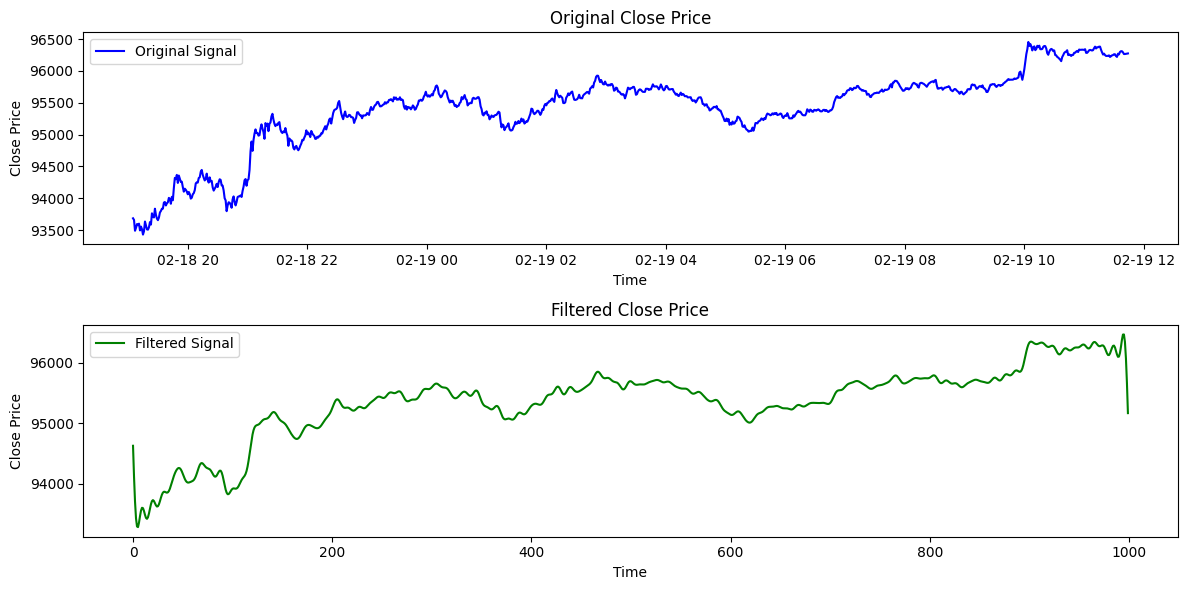

filtered data:                          Open      High       Low     Close     Volume  \
timestamp                                                                
2025-02-18 19:05:00  93734.16  93734.16  93640.77  93684.48   27.40839   
2025-02-18 19:06:00  93684.48  93684.48  93610.00  93659.40   27.60298   
2025-02-18 19:07:00  93659.40  93659.40  93469.05  93489.00  136.49527   
2025-02-18 19:08:00  93489.00  93535.70  93388.09  93535.69   75.40416   
2025-02-18 19:09:00  93535.70  93602.61  93458.41  93593.79   59.41835   
...                       ...       ...       ...       ...        ...   
2025-02-19 11:40:00  96291.00  96291.01  96264.15  96264.16    8.99467   
2025-02-19 11:41:00  96264.15  96283.59  96264.15  96264.15    4.44235   
2025-02-19 11:42:00  96264.16  96270.84  96264.15  96266.53    2.04427   
2025-02-19 11:43:00  96266.53  96270.00  96266.53  96270.00    2.72982   
2025-02-19 11:44:00  96269.99  96273.25  96269.99  96273.25    3.17207   

                     C

ValueError: Expected parameter logits (Tensor of shape (64, 3)) of distribution Categorical(logits: torch.Size([64, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], device='cuda:0', grad_fn=<SubBackward0>)

In [10]:

if __name__ == "__main__":
    main()


2025-02-19 17:42:09,015 INFO: Test Results on Random Data:
2025-02-19 17:42:09,016 INFO: Total Profit: -9.24
2025-02-19 17:42:09,017 INFO: Total Buy Actions: 68
2025-02-19 17:42:09,017 INFO: Total Sell Actions: 40
2025-02-19 17:42:09,018 INFO: Total Hold Actions: 382
2025-02-19 17:42:09,019 INFO: Total Trades: 108
2025-02-19 17:42:09,019 INFO: Win Rate: 1.00%
2025-02-19 17:42:09,020 INFO: Accuracy: 100.00%


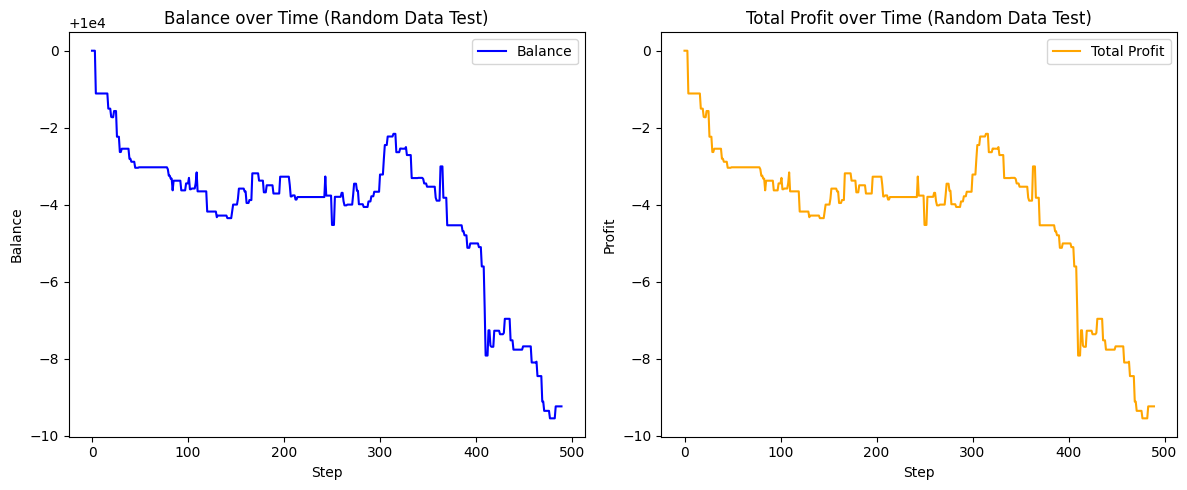

In [ ]:
import numpy as np
import random

# Generate random data (random price values, simulating a price series)
def generate_random_data(n_steps=500):
    # Generate random close prices
    prices = np.cumsum(np.random.randn(n_steps)) + 100  # Start at price of 100
    timestamps = pd.date_range(start='2025-02-19', periods=n_steps, freq='1m')
    random_data = pd.DataFrame({
        'timestamp': timestamps,
        'Open': prices,
        'High': prices + np.random.randn(n_steps),
        'Low': prices - np.random.randn(n_steps),
        'Close': prices,
        'Volume': np.random.rand(n_steps) * 1000
    })
    random_data.set_index('timestamp', inplace=True)
    return random_data

# Generate random data
random_data = generate_random_data()

# Preprocess with noise filtering (same as in the training pipeline)
random_data = noise_filtering(random_data, plot=False)

# Create environment with random data
random_env = TradingEnv(random_data, window_size=20, transaction_cost=0.001, slippage=0.001)

# Load the saved model
model_loaded = PPO.load("adaptive_trading_bot2")
model_loaded.set_env(random_env)

# Run the model on the random data
obs = random_env.reset()
done = False
info_history_random = []
actions_taken = {'buy': 0, 'sell': 0, 'hold': 0}
total_profit = 0
total_trades = 0

while not done:
    action, _ = model_loaded.predict(obs)
    obs, reward, done, info = random_env.step(action)
    info_history_random.append(info)
    
    # Track action counts
    if action == 1:
        actions_taken['buy'] += 1
    elif action == 2:
        actions_taken['sell'] += 1
    else:
        actions_taken['hold'] += 1
    
    # Accumulate total profit
    total_profit += reward
    if reward != 0:
        total_trades += 1

# Calculate win rate and accuracy
successful_trades = total_trades
win_rate = successful_trades / total_trades if total_trades > 0 else 0
accuracy = (successful_trades / total_trades) * 100 if total_trades > 0 else 0

# Print evaluation results
logger.info("Test Results on Random Data:")
logger.info(f"Total Profit: {total_profit:.2f}")
logger.info(f"Total Buy Actions: {actions_taken['buy']}")
logger.info(f"Total Sell Actions: {actions_taken['sell']}")
logger.info(f"Total Hold Actions: {actions_taken['hold']}")
logger.info(f"Total Trades: {total_trades}")
logger.info(f"Win Rate: {win_rate:.2f}%")
logger.info(f"Accuracy: {accuracy:.2f}%")

# Plot results of the random test
plot_results(info_history_random, title_suffix="(Random Data Test)")
